<h1> Laboratory work 2:  Named-entity recognition (NER) </h1>

Authors: Aleksei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion/data" target="_blank">  CoNLL003 (English-version) </a> is used.

In this laboratory work, we explore the fundamentals of Named Entity Recognition (NER), a key NLP task that identifies and categorizes entities in text, such as persons, organizations, and locations. NER is widely used in applications like information extraction and text analysis.

We will use the CoNLL-2003 dataset, a benchmark for NER, which provides annotated text in English and German. In this work, we consider only English language. For English, the dataset includes training, validation, and test sets, with entity categories such as Person (PER), Organization (ORG), Location (LOC), and Miscellaneous (MISC). The annotations follow the BIO tagging scheme, marking tokens as Beginning (B), Inside (I), or Outside (O) of entities.

In [8]:
import pandas as pd
from src.preprocessing import (set_seed,
                               load_sentences,
                               analyze_data_quality,
                               label_frequency_analysis,
                               labels_distribution_charts,
                               rare_and_dominant_categories,
                               entity_neighbors, plot_multiple_entity_neighbors,
                               generate_wordcloud_from_tokens_on_subplots,
                               remove_duplicates, remove_noise_from_data,
                               remove_stop_words_from_dataset,
                               remove_special_characters_from_dataset,
                               evaluate_ner
                               )
from src.RuleBasedApproach import RuleBasedNER

set_seed()

## Download data

In [9]:
train_samples = load_sentences('./data/train.txt')
test_samples = load_sentences('./data/test.txt')
valid_samples = load_sentences('./data/valid.txt')

In [10]:
schema = ['_'] + sorted({tag for sentence in (train_samples + test_samples + valid_samples) 
                             for _, tag in sentence})
schema

['_',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O']

There total have four NER types, LOC, MISC, ORG, PER, combine with the three location type, B,I,O. This task is a 9 classification task.

* O - word doesn’t correspond to any entity.
* B-PER/I-PER - word corresponds to the beginning of / is inside a person entity.
* B-ORG/I-ORG - word corresponds to the beginning of / is inside an organization entity.
* B-LOC/I-LOC - word corresponds to the beginning of / is inside a location entity.
* B-MISC/I-MISC - word corresponds to the beginning of / is inside a miscellaneous entity.

## EDA


### General information about the dataset

In [11]:
print(f"Train set length: {len(train_samples)}, leghth of the longest sentence is {max([len(item) for item in train_samples])}")
print(f"Valid set length: {len(valid_samples)}, leghth of the longest sentence is {max([len(item) for item in valid_samples])}")
print(f"Test set length: {len(test_samples)}, leghth of the longest sentence is {max([len(item) for item in test_samples])}")

Train set length: 14041, leghth of the longest sentence is 113
Valid set length: 3250, leghth of the longest sentence is 109
Test set length: 3453, leghth of the longest sentence is 124


In [12]:
print(f"Train dataset quality:\n {analyze_data_quality(train_samples)}")
print(f"Test dataset quality:\n {analyze_data_quality(test_samples)}")
print(f"Validation dataset quality:\n {analyze_data_quality(valid_samples)}")


Train dataset quality:
 {'total_tokens': 203621, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Test dataset quality:
 {'total_tokens': 46435, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Validation dataset quality:
 {'total_tokens': 51362, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}


### Analysis of entity categories

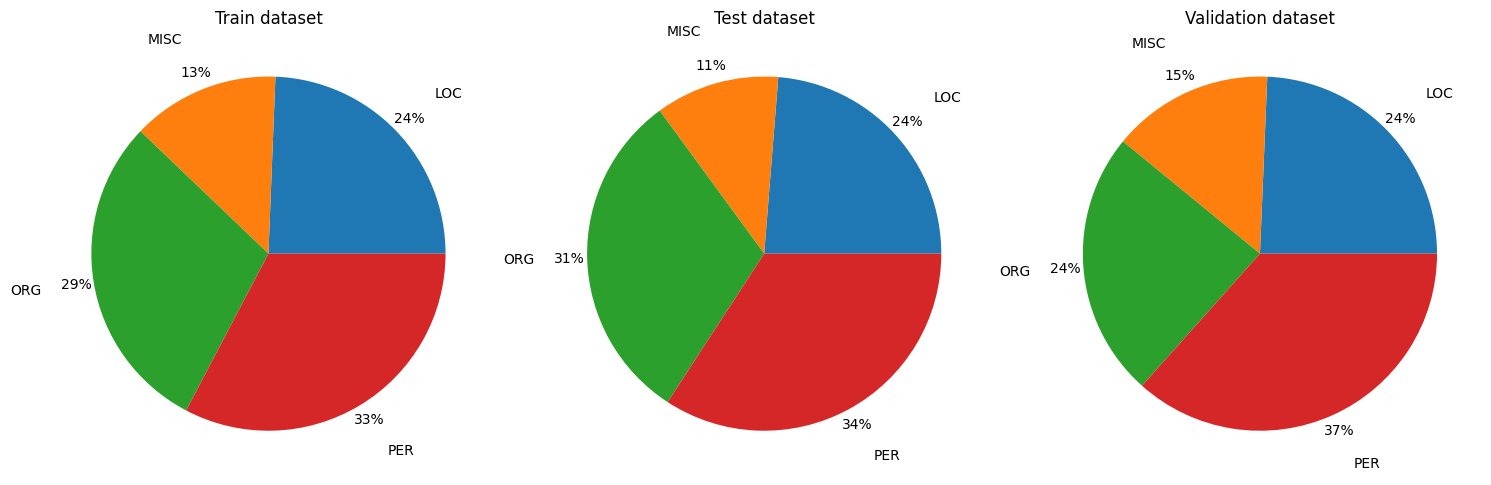

In [13]:
labels_distribution_charts(
    label_frequency_analysis(train_samples),
    label_frequency_analysis(test_samples),
    label_frequency_analysis(valid_samples),
    )

In [14]:
print(f"Rare and dominant entities in train dataset:\n {rare_and_dominant_categories(train_samples)}")
print(f"Rare and dominant entities in test dataset:\n {rare_and_dominant_categories(test_samples)}")
print(f"Rare and dominant entities in validation dataset:\n {rare_and_dominant_categories(valid_samples)}")

Rare and dominant entities in train dataset:
 {'total_tokens': 203621, 'top_categories': {'B-LOC': 3.506514553999833, 'O': 83.2811939829389}, 'worst_categories': {'I-MISC': 0.5672302954999731, 'I-LOC': 0.5682125124618777}}
Rare and dominant entities in test dataset:
 {'total_tokens': 46435, 'top_categories': {'B-LOC': 3.592118014428771, 'O': 82.53041886508022}, 'worst_categories': {'I-MISC': 0.4651663615807042, 'I-LOC': 0.5534618283622268}}
Rare and dominant entities in validation dataset:
 {'total_tokens': 51362, 'top_categories': {'B-PER': 3.58630894435575, 'O': 83.25026284023208}, 'worst_categories': {'I-LOC': 0.5003699232895915, 'I-MISC': 0.6736497799929909}}


### WordCloud

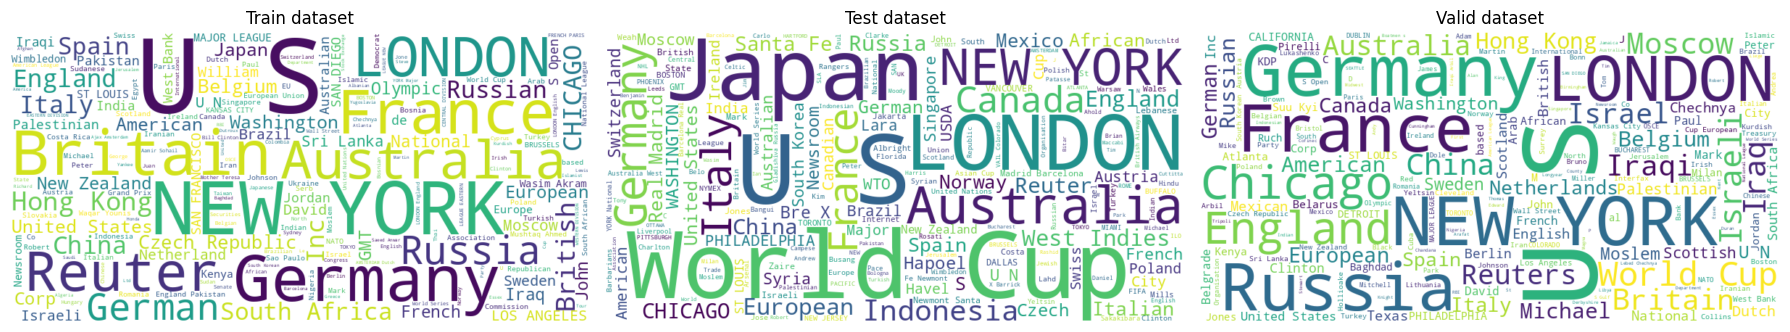

In [15]:
generate_wordcloud_from_tokens_on_subplots(
    train_samples, 
    test_samples, 
    valid_samples
)

### Proposition-level analysis

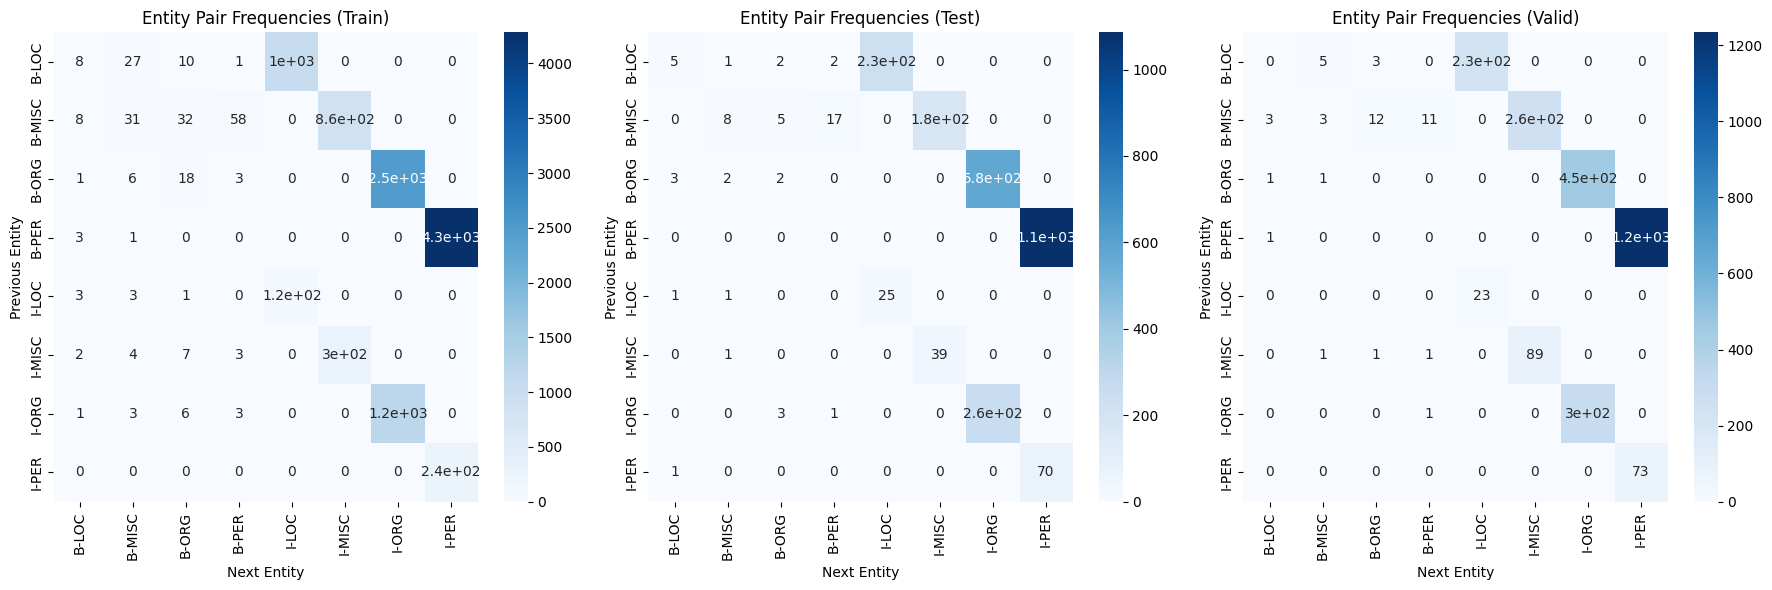

In [16]:
plot_multiple_entity_neighbors(
    entity_neighbors(train_samples),
    entity_neighbors(test_samples),
    entity_neighbors(valid_samples)
)

### Remove duplicate

In [17]:
train_samples = remove_duplicates(train_samples)
test_samples = remove_duplicates(test_samples)
valid_samples = remove_duplicates(valid_samples)

### Remove noise data

In [18]:
train_samples = remove_noise_from_data(train_samples)
test_samples = remove_noise_from_data(test_samples)
valid_samples = remove_noise_from_data(valid_samples)

### Remove stop word

In [19]:
train_samples = remove_stop_words_from_dataset(train_samples)
test_samples = remove_stop_words_from_dataset(test_samples)
valid_samples = remove_stop_words_from_dataset(valid_samples)

### Remove special characters

In [20]:
train_samples = remove_special_characters_from_dataset(train_samples)
test_samples = remove_special_characters_from_dataset(test_samples)
valid_samples = remove_special_characters_from_dataset(valid_samples)

## Rule based approach


In [21]:
from typing import List

def create_corpus(token_sentences: List[list]) -> dict:
    dataset_corpus = []
    for sentence in token_sentences:
        tokens = [token for token, _ in sentence]
        dataset_corpus.append({'text': " ".join(tokens),
                               'target':  sentence})
    return dataset_corpus

In [22]:
train_dataset = create_corpus(train_samples)
test_dataset = create_corpus(test_samples)
val_dataset = create_corpus(valid_samples)

In [23]:
model = RuleBasedNER()
result = model.process_dataset(train_dataset)

In [24]:
metrics = evaluate_ner(result)
rule_based_metric = pd.DataFrame(metrics, columns=list(metrics.keys()), index=['Score'])

In [25]:
rule_based_metric

,accuracy,precision,recall,f1-score
Score,0.51901,0.301088,0.289567,0.284405


# NN

In [11]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003", trust_remote_code=True)
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

In [12]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [13]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [14]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map: 100%|██████████| 3250/3250 [00:00<00:00, 9686.34 examples/s] 


In [15]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

NUM_EPOCHS=0.0001


args = TrainingArguments(
    "data/checkpoint",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    learning_rate=2e-5,
    num_train_epochs=0.0001,
    weight_decay=0.01
)

/Users/alexgiving/Documents/iad/nlp-ner/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_8832/3164488976.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

100%|██████████| 1/1 [02:02<00:00, 122.54s/it]


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]